In [1]:
# Import Libraries
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import (
    BatchNormalization, Conv2D, MaxPooling2D, Flatten, Dropout, Dense
)
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
from tqdm import tqdm
import cv2
import sklearn
import skimage
from skimage.transform import resize
import random
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score
import seaborn as sns
sns.set()

In [2]:
train = "../input/wildfire-detection-image-data/forest_fire/Training and Validation"

test = "../input/wildfire-detection-image-data/forest_fire/Testing"



LOAD_FROM_IMAGES = True

def get_data(folder):
    x = []
    y = []
    for folderName in os.listdir(folder):
        if not folderName.startswith("."):
            if folderName in ["nofire"]:
                label = 0
            elif folderName in ["fire"]:
                label = 1
            else:
                label = 2
            for image_filename in tqdm(os.listdir(folder +"/" +folderName+"/")):
                img_file = cv2.imread(folder + "/" +folderName + "/" + image_filename)
                if img_file is not None:
                    img_arr = np.asarray(img_file)
                    x.append(img_arr)
                    y.append(label)
    x = np.asarray(x)
    y = np.asarray(y)
    return x,y

if LOAD_FROM_IMAGES:
    X_train,y_train = get_data(train)
    X_test, y_test = get_data(test)
    
    np.save("xtrain.npy",X_train)
    np.save("ytrain.npy",y_train)
    np.save("xtest.npy",X_test)
    np.save("ytest.npy",y_test)
else:
    X_train = np.load("xtrain.npy")
    y_train = np.load("ytrain.npy")
    X_test = np.load("xtest.npy")
    y_test = np.load("ytest.npy")

from sklearn.model_selection import train_test_split

# Split the data
X_train, X_valid, y_train, y_valid = train_test_split(X_train,y_train,test_size=0.2,shuffle=True)

# Image Normalization
X_train, X_valid, X_test = X_train / 255.0, X_valid / 255.0, X_test / 255.0

100%|██████████| 22/22 [00:00<00:00, 260.84it/s]


In [3]:
X_train.shape

(1465, 250, 250, 3)

In [4]:
model = models.Sequential()

model.add(layers.Conv2D(96,(11,11),strides=(4, 4),activation="relu",input_shape=(227,227,3)))
model.add(BatchNormalization())
model.add(layers.MaxPooling2D((3,3), strides=(2,2)))

model.add(layers.Conv2D(256,(5,5),activation="relu",padding="same"))
model.add(BatchNormalization())
model.add(layers.MaxPooling2D((3,3), strides=(2,2)))

model.add(layers.Conv2D(384,(3,3),activation="relu",padding="same"))
model.add(BatchNormalization())
model.add(layers.Conv2D(384,(3,3),activation="relu",padding="same"))
model.add(BatchNormalization())
model.add(layers.Conv2D(256,(3,3),activation="relu",padding="same"))
model.add(BatchNormalization())
model.add(layers.MaxPooling2D((3,3), strides=(2,2)))

model.add(layers.Flatten())

# Fully connected
model.add(layers.Dense(4096,activation="relu"))
model.add(Dropout(0.5))

model.add(layers.Dense(4096,activation="relu"))
model.add(Dropout(0.5))

model.add(layers.Dense(2,activation="softmax"))

2022-05-24 01:14:50.376058: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-24 01:14:50.520900: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-24 01:14:50.521723: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-24 01:14:50.522924: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [5]:
model.compile(optimizer = "adam" , loss = "sparse_categorical_crossentropy", metrics=["accuracy"])

In [6]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor="accuracy",
    patience=5,
    restore_best_weights=True)

In [7]:
batch_size=8
epochs=50

history =  model.fit(X_train,y_train,validation_data=(X_valid,y_valid),batch_size=batch_size,
                    epochs=epochs,verbose=1,callbacks=[early_stopping])

2022-05-24 01:14:53.821886: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1098750000 exceeds 10% of free system memory.
2022-05-24 01:14:55.027469: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1098750000 exceeds 10% of free system memory.
2022-05-24 01:14:55.832921: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-05-24 01:14:57.373382: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


184/184 [==============================] - 12s 24ms/step - loss: 15.5750 - accuracy: 0.8096 - val_loss: 6.9496 - val_accuracy: 0.7357
Epoch 2/50
184/184 [==============================] - 4s 20ms/step - loss: 4.3993 - accuracy: 0.8614 - val_loss: 3.6199 - val_accuracy: 0.8038
Epoch 3/50
184/184 [==============================] - 4s 19ms/step - loss: 3.8060 - accuracy: 0.8396 - val_loss: 2.4075 - val_accuracy: 0.8992
Epoch 4/50
184/184 [==============================] - 4s 19ms/step - loss: 1.5764 - accuracy: 0.8724 - val_loss: 1.1365 - val_accuracy: 0.9373
Epoch 5/50
184/184 [==============================] - 4s 20ms/step - loss: 3.5938 - accuracy: 0.8546 - val_loss: 3.8098 - val_accuracy: 0.8065
Epoch 6/50
184/184 [==============================] - 4s 19ms/step - loss: 2.8005 - accuracy: 0.8205 - val_loss: 4.9927 - val_accuracy: 0.7684
Epoch 7/50
184/184 [==============================] - 4s 19ms/step - loss: 1.5566 - accuracy: 0.8765 - val_loss: 0.2767 - val_accuracy: 0.9401
Epoch 8/

In [8]:
score = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=1)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

9/9 [==============================] - 0s 18ms/step - loss: 0.4498 - accuracy: 0.9412
Test loss: 0.4498293101787567
Test accuracy: 0.9411764740943909


In [9]:
model.save("wildfire_model.h5")

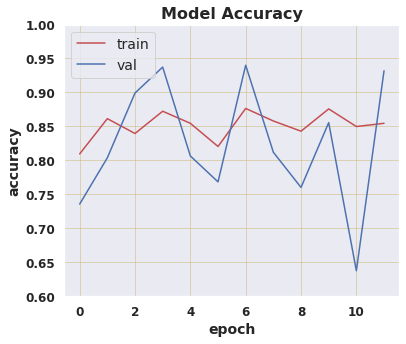

In [10]:
from matplotlib import pyplot as plt
%matplotlib inline 

plt.figure(figsize=(6, 5))
plt.plot(history.history['accuracy'], color='r')
plt.plot(history.history['val_accuracy'], color='b')
plt.title('Model Accuracy', weight='bold', fontsize=16)
plt.ylabel('accuracy', weight='bold', fontsize=14)
plt.xlabel('epoch', weight='bold', fontsize=14)
plt.ylim(0.6, 1.0)
plt.xticks(weight='bold', fontsize=12)
plt.yticks(weight='bold', fontsize=12)
plt.legend(['train', 'val'], loc='upper left', prop={'size': 14})
plt.grid(color = 'y', linewidth='0.5')
plt.show()

              precision    recall  f1-score   support

           0       0.94      0.98      0.96        46
           1       0.95      0.86      0.90        22

    accuracy                           0.94        68
   macro avg       0.94      0.92      0.93        68
weighted avg       0.94      0.94      0.94        68



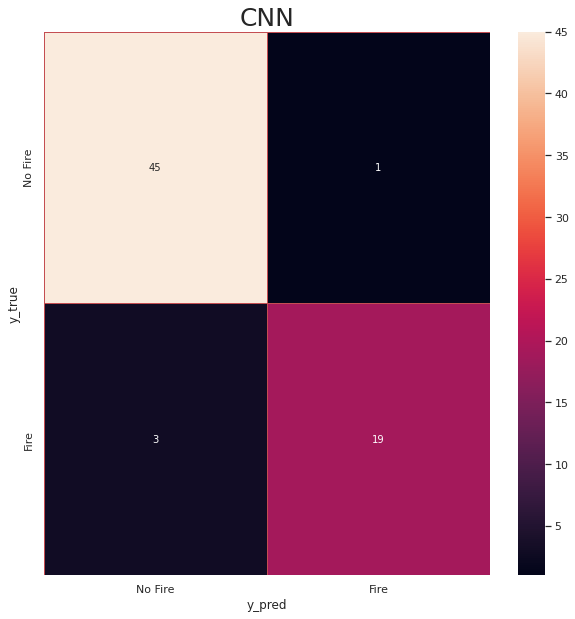

In [11]:
y_test_pred = model.predict(X_test)

y_pred = (y_test_pred > 0.5)
y_pred=np.argmax(y_pred, axis=1)

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

y_pred.shape

y_test.shape

print(classification_report(y_test, y_pred)) 

def confusion(y_test,y_test_pred,X):
    names=['No Fire','Fire']
    cm=confusion_matrix(y_test,y_test_pred)
    f,ax=plt.subplots(figsize=(10,10))
    sns.heatmap(cm,annot=True,linewidth=.5,linecolor="r",fmt=".0f",ax=ax)
    plt.title(X, size = 25)
    plt.xlabel("y_pred")
    plt.ylabel("y_true")
    ax.set_xticklabels(names)
    ax.set_yticklabels(names)
    plt.show()

    return

confusion(y_test,y_pred,"CNN")